In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, precision_score, recall_score
from tensorflow.keras import layers
import tensorflow as tf

import semua library yang dibutuhkan

In [19]:
pip install kagglehub


In [20]:
pip install kaggle

install kagglehub agar bisa memuat data dari kaggle, karena disini saya menggunakan data dari kaggle

In [21]:
import kagglehub
import pandas as pd
import os

# Download dataset
path = kagglehub.dataset_download("dev0914sharma/dataset")
print("Path to dataset files:", path)

# Load Dataset.csv
csv_path_dataset = os.path.join(path, 'Dataset.csv')
df = pd.read_csv(csv_path_dataset)

# Load Movie_Id_Titles.csv
csv_path_titles = os.path.join(path, 'Movie_Id_Titles.csv')
titles = pd.read_csv(csv_path_titles)

# Informasi Dataset.csv
print("\nInformasi Dataset.csv:")
print("Jumlah Baris (Data):", len(df))
print("Jumlah Kolom (Fitur):", len(df.columns))
print("\nInfo Detil Dataset.csv:")
print(df.info())

# Informasi Movie_Id_Titles.csv
print("\nInformasi Movie_Id_Titles.csv:")
print("Jumlah Baris (Data):", len(titles))
print("Jumlah Kolom (Fitur):", len(titles.columns))
print("\nInfo Detil Movie_Id_Titles.csv:")
print(titles.info())


Path to dataset files: /root/.cache/kagglehub/datasets/dev0914sharma/dataset/versions/1

Informasi Dataset.csv:
Jumlah Baris (Data): 100003
Jumlah Kolom (Fitur): 4

Info Detil Dataset.csv:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100003 entries, 0 to 100002
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   user_id    100003 non-null  int64
 1   item_id    100003 non-null  int64
 2   rating     100003 non-null  int64
 3   timestamp  100003 non-null  int64
dtypes: int64(4)
memory usage: 3.1 MB
None

Informasi Movie_Id_Titles.csv:
Jumlah Baris (Data): 1682
Jumlah Kolom (Fitur): 2

Info Detil Movie_Id_Titles.csv:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1682 entries, 0 to 1681
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   item_id  1682 non-null   int64 
 1   title    1682 non-null   object
dtypes: int64(1), object(1)
memory usage: 26.4+ KB
None

melihat dan mengecek tipe data yang akan digunakan

#data preparation

In [22]:
# Gabungkan Dataset.csv dan Movie_Id_Titles.csv
data = pd.merge(df, titles, on='item_id', how='inner')

# Informasi Data Gabungan
print("\nInformasi Data Gabungan:")
print("Jumlah Baris (Data):", len(data))
print("Jumlah Kolom (Fitur):", len(data.columns))
print("\nInfo Detil Data Gabungan:")
print(data.info())

# Menampilkan data gabungan
print("\nData Gabungan (5 Baris Pertama):")
print(data.head())


Informasi Data Gabungan:
Jumlah Baris (Data): 100003
Jumlah Kolom (Fitur): 5

Info Detil Data Gabungan:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100003 entries, 0 to 100002
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    100003 non-null  int64 
 1   item_id    100003 non-null  int64 
 2   rating     100003 non-null  int64 
 3   timestamp  100003 non-null  int64 
 4   title      100003 non-null  object
dtypes: int64(4), object(1)
memory usage: 3.8+ MB
None

Data Gabungan (5 Baris Pertama):
   user_id  item_id  rating  timestamp                            title
0        0       50       5  881250949                 Star Wars (1977)
1        0      172       5  881250949  Empire Strikes Back, The (1980)
2        0      133       1  881250949        Gone with the Wind (1939)
3      196      242       3  881250949                     Kolya (1996)
4      186      302       3  891717742         L.A. Conf

merged data yang ada pada Movie_Id_Titles.csv dengan Dataset.csv untuk memudahkan proses analisis dan evaluasi

In [23]:
# Memeriksa missing values
print(data.isnull().sum())

# Fungsi remove_outliers dengan sedikit modifikasi
def remove_outliers(df, columns):
    df_clean = df.copy()
    removed_rows = []
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Simpan baris yang akan dihapus
        outlier_rows = df_clean[(df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)].index
        removed_rows.extend(outlier_rows)

    # Hapus baris outlier
    df_clean = df_clean.drop(index=list(set(removed_rows)))
    return df_clean

# Kolom numerik yang akan diperiksa untuk outlier (kecuali rating)
numeric_columns = ['user_id', 'item_id', 'timestamp']

# Menampilkan jumlah baris sebelum menghapus outlier
print(f"Jumlah baris sebelum menghapus outlier: {len(data)}")

# Menghapus outlier
data_clean = remove_outliers(data, numeric_columns)

# Menampilkan jumlah baris setelah menghapus outlier
print(f"Jumlah baris setelah menghapus outlier: {len(data_clean)}")

# Menampilkan persentase data yang dihapus
percent_removed = ((len(data) - len(data_clean)) / len(data)) * 100
print(f"Persentase data yang dihapus: {percent_removed:.2f}%")

user_id      0
item_id      0
rating       0
timestamp    0
title        0
dtype: int64
Jumlah baris sebelum menghapus outlier: 100003
Jumlah baris setelah menghapus outlier: 98654
Persentase data yang dihapus: 1.35%


Kode ini dirancang untuk membersihkan dataset dengan:
1. Memeriksa missing values.
2. Mengidentifikasi dan menghapus outlier menggunakan metode IQR.

In [24]:
# Mengubah `user_id` menjadi list tanpa nilai yang sama
user_ids = data['user_id'].unique().tolist()
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}

# Mengubah `item_id` menjadi list tanpa nilai yang sama
item_ids = data['item_id'].unique().tolist()
item_to_item_encoded = {x: i for i, x in enumerate(item_ids)}
item_encoded_to_item = {i: x for i, x in enumerate(item_ids)}

Kode ini digunakan untuk encoding kolom user_id dan item_id menjadi bentuk numerik agar dapat digunakan dalam model machine learning, khususnya model rekomendasi.
dengan cara
1. menghilangkan dulikasi
2. Membuat Mapping Encoding

In [25]:
# Mapping user_id dan item_id ke data gabungan
data['user'] = data['user_id'].map(user_to_user_encoded)
data['item'] = data['item_id'].map(item_to_item_encoded)

# Informasi dataset
num_users = len(user_to_user_encoded)
num_items = len(item_encoded_to_item)

# Mengubah rating menjadi float dan menghitung nilai min/max
data['rating'] = data['rating'].values.astype(np.float32)
min_rating = data['rating'].min()
max_rating = data['rating'].max()

In [26]:
# Normalisasi rating
data['normalized_rating'] = data['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating))

# Membagi data menjadi train dan validasi (80:20)
data = data.sample(frac=1, random_state=42)  # Mengacak dataset
x = data[['user', 'item']].values
y = data['normalized_rating'].values

train_indices = int(0.8 * data.shape[0])
x_train, x_val = x[:train_indices], x[train_indices:]
y_train, y_val = y[:train_indices], y[train_indices:]

1. Normalisasi Rating: Mengubah rating asli ke rentang 0 hingga 1 agar lebih konsisten.
2. Pengacakan Data: Mengacak urutan data untuk memastikan pembagian data yang tidak bias.
3. Pembagian Data: Membagi data menjadi dua set: pelatihan (80%) dan validasi (20%) untuk melatih dan mengevaluasi model.

#Modelling

In [27]:
# Membuat model rekomendasi
class RecommenderNet(tf.keras.Model):
    def __init__(self, num_users, num_items, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.user_embedding = layers.Embedding(
            num_users, embedding_size, embeddings_initializer="he_normal", embeddings_regularizer=tf.keras.regularizers.l2(1e-6))
        self.user_bias = layers.Embedding(num_users, 1)
        self.item_embedding = layers.Embedding(
            num_items, embedding_size, embeddings_initializer="he_normal", embeddings_regularizer=tf.keras.regularizers.l2(1e-6))
        self.item_bias = layers.Embedding(num_items, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        item_vector = self.item_embedding(inputs[:, 1])
        item_bias = self.item_bias(inputs[:, 1])

        dot_user_item = tf.tensordot(user_vector, item_vector, axes=2)
        x = dot_user_item + user_bias + item_bias
        return tf.nn.sigmoid(x)

Membuat model machine learning Collaborative Filtering berbasis Matrix Factorization dengan teknik embedding

In [28]:
# Inisialisasi dan kompilasi model
model = RecommenderNet(num_users, num_items, embedding_size=50)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()],
)

inisialisasi dan kompilasi model untuk model RecommenderNet yang telah dibuat sebelumnya

In [29]:
# Melatih model
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=10,
    validation_data=(x_val, y_val),
)

Epoch 1/10
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.6697 - root_mean_squared_error: 0.2921 - val_loss: 0.6359 - val_root_mean_squared_error: 0.2619
Epoch 2/10
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.6326 - root_mean_squared_error: 0.2603 - val_loss: 0.6280 - val_root_mean_squared_error: 0.2545
Epoch 3/10
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.6220 - root_mean_squared_error: 0.2507 - val_loss: 0.6206 - val_root_mean_squared_error: 0.2481
Epoch 4/10
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.6195 - root_mean_squared_error: 0.2480 - val_loss: 0.6208 - val_root_mean_squared_error: 0.2485
Epoch 5/10
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.6169 - root_mean_squared_error: 0.2462 - val_loss: 0.6180 - val_root_mean_squared_error: 0.2460
Epoch 6/10
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.6173 - root_mean_squared_error: 0.2459 - val_loss: 0.6171 - val_root_mean_squared_error: 0.2453
Epoch 7/10
1251/1251 ━━━━━━━━━━━━━━━━━

melatih model

626/626 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
RMSE: 0.2443
MAE: 0.1967
Precision: 0.9080
Recall: 0.7751


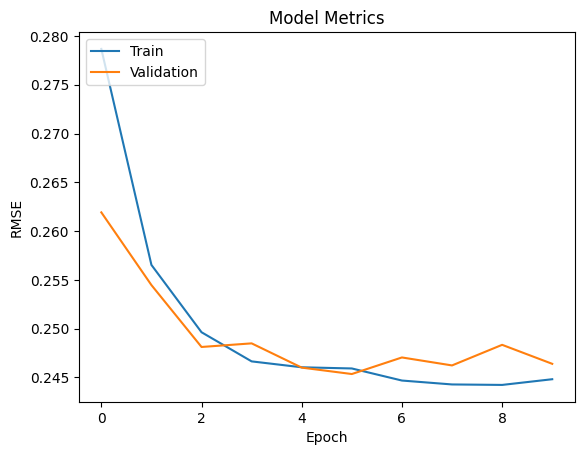

In [30]:
# Evaluasi metrik tambahan
y_pred = model.predict(x_val).flatten()
y_pred_binary = np.where(y_pred >= 0.5, 1, 0)
y_val_binary = np.where(y_val >= 0.5, 1, 0)

# Menghitung RMSE (Root Mean Squared Error)
rmse = np.sqrt(np.mean((y_val - y_pred) ** 2))

# Menghitung MAE (Mean Absolute Error)
mae = mean_absolute_error(y_val, y_pred)

# Menghitung Precision dan Recall
precision = precision_score(y_val_binary, y_pred_binary, zero_division=0)
recall = recall_score(y_val_binary, y_pred_binary, zero_division=0)

# Menampilkan metrik
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Visualisasi metrik RMSE selama pelatihan
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('Model Metrics')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


Kode ini digunakan untuk mengukur performa model rekomendasi menggunakan beberapa metrik: RMSE untuk mengukur kesalahan kuadrat rata-rata, MAE untuk mengukur kesalahan absolut rata-rata, Precision untuk menilai akurasi prediksi positif, dan Recall untuk mengevaluasi kemampuan model dalam menangkap kasus positif yang sebenarnya. Kode ini juga menampilkan grafik yang menunjukkan perbandingan performa RMSE antara data pelatihan dan validasi pada setiap epoch.

In [31]:
#rekomendasi untuk pengguna
user_id = data['user_id'].sample(1).iloc[0]
user_encoder = user_to_user_encoded[user_id]
movies_watched = data[data['user_id'] == user_id]['item_id'].tolist()

not_watched = [item for item in item_ids if item not in movies_watched]
not_watched_encoded = [[item_to_item_encoded[item]] for item in not_watched]
user_movie_array = np.hstack(([[user_encoder]] * len(not_watched), not_watched_encoded))

ratings = model.predict(user_movie_array).flatten()
top_indices = ratings.argsort()[-10:][::-1]
recommended_item_ids = [item_encoded_to_item[i] for i in top_indices]

print(f"Rekomendasi untuk pengguna {user_id} top 10:")
for item in recommended_item_ids:
    print(data[data['item_id'] == item]['title'].iloc[0])

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step
Rekomendasi untuk pengguna 761 top 10:
Silence of the Lambs, The (1991)
Birds, The (1963)
Boot, Das (1981)
Murder at 1600 (1997)
U Turn (1997)
Cop Land (1997)
Mr. Holland's Opus (1995)
Sense and Sensibility (1995)
Some Folks Call It a Sling Blade (1993)
While You Were Sleeping (1995)


menampilkan hasil dari rekomendasi